In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install datasets rouge py7zr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 88.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.7/413.7 kB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found exis

In [ ]:
import torch
import torch.nn as nn
from transformers import T5ForConditionalGeneration, T5Tokenizer, AdamW, get_linear_schedule_with_warmup
from datasets import load_dataset
from rouge import Rouge
import numpy as np
from torch.utils.data import DataLoader

In [ ]:
# Load the SAMSum dataset
dataset = load_dataset('samsum')
train_dataset = dataset['train']
val_dataset = dataset['validation']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.04k [00:00<?, ?B/s]

samsum.py:   0%|          | 0.00/3.36k [00:00<?, ?B/s]

The repository for samsum contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/samsum.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


corpus.7z:   0%|          | 0.00/2.94M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

In [ ]:
# Load T5 model and tokenizer
model = T5ForConditionalGeneration.from_pretrained('t5-base')
tokenizer = T5Tokenizer.from_pretrained('t5-base')

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [ ]:
def collate_fn(batch, tokenizer, max_length):
    inputs = tokenizer([sample['dialogue'] for sample in batch],
                       return_tensors='pt', max_length=max_length, truncation=True, padding=True)
    labels = tokenizer([sample['summary'] for sample in batch],
                       return_tensors='pt', max_length=max_length, truncation=True, padding=True)
    inputs['labels'] = labels.input_ids
    return inputs

In [ ]:
def train_model(model, tokenizer, train_dataset, val_dataset, num_epochs=8, batch_size=8, max_length=512, lr=5e-5):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                              collate_fn=lambda batch: collate_fn(batch, tokenizer, max_length))
    val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=lambda batch: collate_fn(batch, tokenizer, max_length))

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)  # Reduce learning rate after 2 epochs

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch in train_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            optimizer.zero_grad()
            output = model(**batch)
            loss = output.loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss}')
        scheduler.step()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                output = model(**batch)
                val_loss += output.loss.item()

        avg_val_loss = val_loss / len(val_loader)
        print(f'Validation Loss: {avg_val_loss}')

    return model

In [ ]:
trained_model = train_model(model, tokenizer, train_dataset, val_dataset)

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch 1/8, Training Loss: 0.9726273450640462
Validation Loss: 0.7708676581822552
Epoch 2/8, Training Loss: 0.7972516352138871
Validation Loss: 0.7508447939909778
Epoch 3/8, Training Loss: 0.7270530924993799
Validation Loss: 0.7513123192254779
Epoch 4/8, Training Loss: 0.6807963635517642
Validation Loss: 0.7477269979935248
Epoch 5/8, Training Loss: 0.6375954313594019
Validation Loss: 0.7553648786637389
Epoch 6/8, Training Loss: 0.6048260964898152
Validation Loss: 0.7659861937309932
Epoch 7/8, Training Loss: 0.5701215931666402
Validation Loss: 0.7783844444936919
Epoch 8/8, Training Loss: 0.5435976928724916
Validation Loss: 0.7845580864299848


In [ ]:
def calculate_rouge_scores(model, tokenizer, dataset, batch_size=8, max_length=512):
    rouge = Rouge()
    device = next(model.parameters()).device
    hypotheses = []
    references = []

    loader = DataLoader(dataset, batch_size=batch_size, collate_fn=lambda batch: collate_fn(batch, tokenizer, max_length))
    for batch in loader:
        # Get input_ids and move them to the device
        input_ids = batch['input_ids'].to(device)
        with torch.no_grad():
            # Generate summaries
            summary_ids = model.generate(input_ids, max_length=max_length, num_beams=4, early_stopping=True)
        # Decode the generated summaries
        hypotheses.extend(tokenizer.batch_decode(summary_ids, skip_special_tokens=True))
        # Decode the actual summaries
        references.extend(tokenizer.batch_decode(batch['labels'], skip_special_tokens=True))

    # Calculate ROUGE scores
    scores = rouge.get_scores(hypotheses, references, avg=True)
    return scores

In [ ]:
val_scores = calculate_rouge_scores(trained_model, tokenizer, val_dataset)
print(f'ROUGE Scores: {val_scores}')

ROUGE Scores: {'rouge-1': {'r': 0.5134144753532899, 'p': 0.5329722057861404, 'f': 0.5019187228852919}, 'rouge-2': {'r': 0.26280449801629263, 'p': 0.2752271477414095, 'f': 0.2558450525752384}, 'rouge-l': {'r': 0.48006166686386914, 'p': 0.49781857309308025, 'f': 0.4689623694617791}}


In [ ]:
!pip install matplotlib

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/abstractive-model-sihanas.pth')

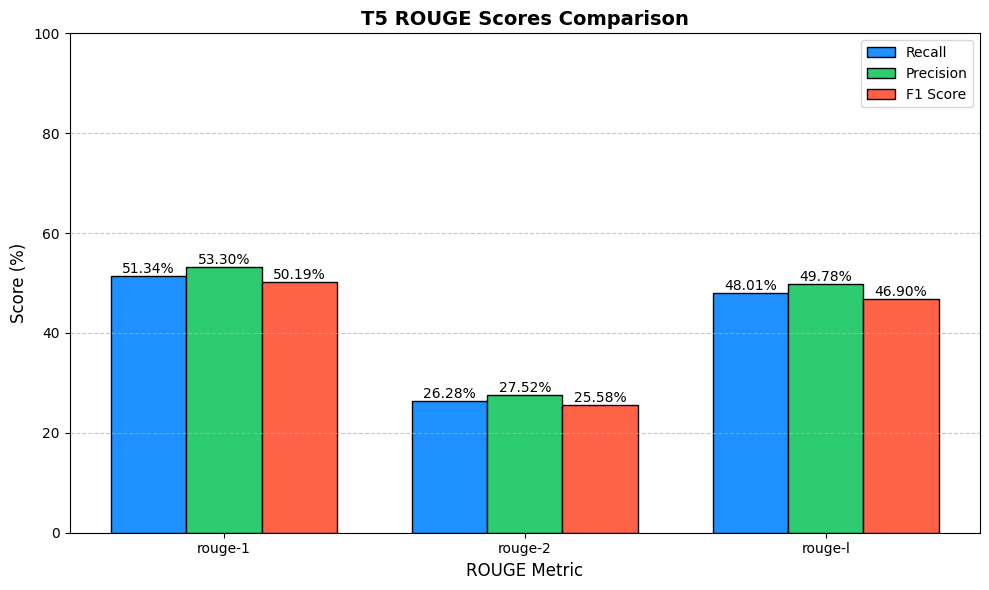

In [ ]:
import matplotlib.pyplot as plt

# ROUGE Scores Data
rouge_scores = {
    'rouge-1': {'r': 0.5134144753532899, 'p': 0.5329722057861404, 'f': 0.5019187228852919},
    'rouge-2': {'r': 0.26280449801629263, 'p': 0.2752271477414095, 'f': 0.2558450525752384},
    'rouge-l': {'r': 0.48006166686386914, 'p': 0.49781857309308025, 'f': 0.4689623694617791}
}

# Extract the data for plotting
metrics = ['rouge-1', 'rouge-2', 'rouge-l']
recalls = [rouge_scores[metric]['r'] * 100 for metric in metrics]
precisions = [rouge_scores[metric]['p'] * 100 for metric in metrics]
f1_scores = [rouge_scores[metric]['f'] * 100 for metric in metrics]

# Plotting the ROUGE Scores
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each metric
width = 0.25  # Increased bar width
x = range(len(metrics))  # x-axis positions

ax.bar([i - width for i in x], recalls, width, label='Recall', color='#1E90FF', edgecolor='black')
ax.bar(x, precisions, width, label='Precision', color='#2ECC71', edgecolor='black')
ax.bar([i + width for i in x], f1_scores, width, label='F1 Score', color='#FF6347', edgecolor='black')

# Adding labels and title
ax.set_xlabel('ROUGE Metric', fontsize=12)
ax.set_ylabel('Score (%)', fontsize=12)
ax.set_title('T5 ROUGE Scores Comparison', fontsize=14, fontweight='bold')

# Set x-ticks and x-axis labels
ax.set_xticks(x)
ax.set_xticklabels(metrics)

# Show legend
ax.legend(loc='upper right')

# Show gridlines for better readability
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# Adjust y-axis to start from 0 and end at 100
ax.set_ylim(0, 100)

# Add value labels on top of each bar
for i, metric in enumerate(metrics):
    ax.text(i - width, recalls[i], f'{recalls[i]:.2f}%', ha='center', va='bottom')
    ax.text(i, precisions[i], f'{precisions[i]:.2f}%', ha='center', va='bottom')
    ax.text(i + width, f1_scores[i], f'{f1_scores[i]:.2f}%', ha='center', va='bottom')

# Tight layout to prevent cutting off labels
plt.tight_layout()

# Display the plot
plt.show()